<a href="https://colab.research.google.com/github/ZeynepRuveyda/classification_automi/blob/main/pytorch_cnn_binary_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and load dataset

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import seaborn as sns
from tqdm.notebook import tqdm
import copy
import os
import torch
from PIL import Image
from PIL import Image, ImageDraw
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install torchsummary

# Creating csv files

In [ ]:
def create_csv_files():
  # assign directory
  dir_T = "/content/drive/Shareddrives/Automi_Team/Engineering/Datasets/LISI/LISI-SOL/T-classification/T"
  dir_No_T = "/content/drive/Shareddrives/Automi_Team/Engineering/Datasets/LISI/LISI-SOL/T-classification/No T"
  T_images_names = []
  NoT_images_names = []
  label_T = []
  label_NoT = []
  for filename in os.scandir(dir_T):
      if filename.is_file():
        T_images_names.append(filename.name)
        label_T.append(1)
  for filename in os.scandir(dir_No_T):
      if filename.is_file():
        NoT_images_names.append(filename.name)
        label_NoT.append(0)

  df  = pd.DataFrame({'id':T_images_names + NoT_images_names,
        'label':label_T+label_NoT})
  df.to_csv('train_labels.csv', index=False)
  return df

In [ ]:
labels_df = create_csv_files()

In [ ]:
labels_df.head()

id  label
0  LISI-22-012-357949.png      1
1  LISI-22-012-354107.png      1
2  LISI-22-012-323062.png      1
3  LISI-22-012-349659.png      1
4  LISI-22-012-321522.png      1

In [ ]:
labels_df.tail()

id  label
376  LISI-22-012-332695.png      0
377  LISI-22-012-333098.png      0
378  LISI-22-012-335214.png      0
379  LISI-22-012-350288.png      0
380  LISI-22-012-331868.png      0

In [ ]:
# No duplicate ids found
labels_df[labels_df.duplicated(keep=False)]

Empty DataFrame
Columns: [id, label]
Index: []

In [ ]:
labels_df['label'].value_counts()

0    229
1    152
Name: label, dtype: int64

#Image Processing

### <b><span style='color:#5D2ECC'>1.5</span> | DATA SAMPLES</b>


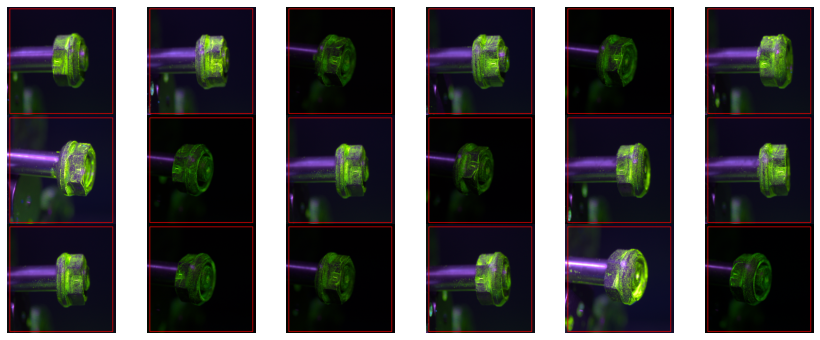

In [ ]:
# data is stored here
imgpath ="/content/drive/Shareddrives/Automi_Team/Engineering/Datasets/LISI/LISI-SOL/T-classification/All"
T = labels_df.loc[labels_df['label']==1]['id'].values # get the ids of T cases
No_T = labels_df.loc[labels_df['label']==0]['id'].values # get the ids of the NO_T cases

nrows,ncols=3,6
fig,ax = plt.subplots(nrows,ncols,figsize=(15,6))
plt.subplots_adjust(wspace=0, hspace=0) 
for i,j in enumerate(T[:nrows*ncols]):
    fname = os.path.join(imgpath ,j)
    img = Image.open(fname)
    idcol = ImageDraw.Draw(img)
    idcol.rectangle(((15,15),(630,640)),outline='red',width = 4)
    plt.subplot(nrows, ncols, i+1) 
    plt.imshow(np.array(img))
    plt.axis('off')

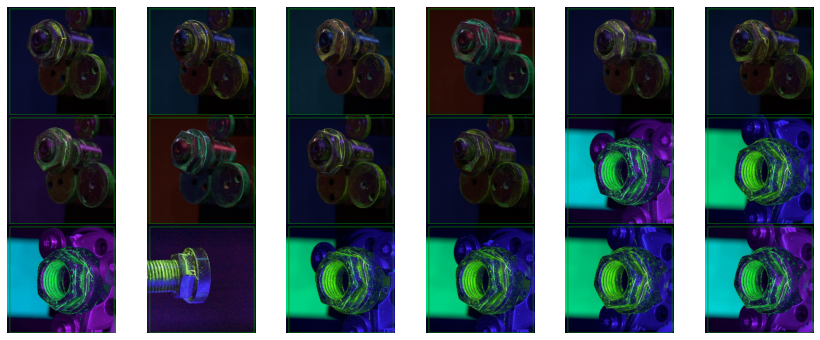

In [ ]:
plt.rcParams['figure.figsize'] = (15, 6)
plt.subplots_adjust(wspace=0, hspace=0)

nrows,ncols=3,6
for i,j in enumerate(No_T[:nrows*ncols]):
    fname = os.path.join(imgpath ,j)
    img = Image.open(fname)
    idcol = ImageDraw.Draw(img)
    idcol.rectangle(((15,15),(630,640)),outline='green',width = 4)
    plt.subplot(nrows, ncols, i+1) 
    plt.imshow(np.array(img))
    plt.axis('off')

<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#5D2ECC;
       font-size:220%;
       font-family:Nexa;
       letter-spacing:0.5px">
    <p style="padding: 20px;
          color:white;">
        <b>2 |</b> CREATING A CUSTOM DATASET
    </p>
</div>


In [ ]:
# fix torch random seed
torch.manual_seed(0)

class pytorch_data(Dataset):
    
    def __init__(self, data_dir, transform):      
    
        # Get Image File Names
        data=os.path.join(data_dir)  # directory of files
        file_names = os.listdir(data) # get list of images in that directory
        self.full_filenames = [os.path.join(data, f) for f in file_names]   # get the full path to images
        
        # Get Labels
         
        labels_df=pd.read_csv("/content/train_labels.csv")
        labels_df.set_index("id", inplace=True) # set data frame index to id
        self.labels = [labels_df.loc[filename].values[0] for filename in file_names] # obtain labels from df
        self.transform = transform
      
    def __len__(self):
        return len(self.full_filenames) # size of dataset
      
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  # Open Image with PIL
        image = self.transform(image) # Apply Specific Transformation to Image
        return image, self.labels[idx]

In [ ]:
# define transformation that converts a PIL image into PyTorch tensors.
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.Resize(512),transforms.ToTensor()])

In [ ]:
# Define an object of the custom dataset for the train folder.
data_dir = '/content/drive/Shareddrives/Automi_Team/Engineering/Datasets/LISI/LISI-SOL/T-classification/All'
img_dataset = pytorch_data(data_dir, data_transformer)

In [ ]:
# load an example tensor
img,label=img_dataset[10]
print(img.shape,torch.min(img),torch.max(img))

torch.Size([3, 512, 512]) tensor(0.) tensor(0.9843)


<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#5D2ECC;
       font-size:220%;
       font-family:Nexa;
       letter-spacing:0.5px">
    <p style="padding: 20px;
          color:white;">
        <b>3 |</b> SPLITTING THE DATASET
    </p>
</div>



In [ ]:
len_img=len(img_dataset)
len_train = int(0.90*len_img)
len_test = len_img - len_train
img_ts,test_ts=random_split(img_dataset,[len_train,len_test]) 
len_img = len_train
len_train=int(0.8*len_img)
len_val = len_img - len_train
train_ts,val_ts=random_split(img_ts,[len_train,len_val])


# Split Pytorch tensor

image_datasets ={"train":train_ts , "val":val_ts, "test":test_ts}
for x in ['train', 'val','test']:
  dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
print("train dataset size:", len(train_ts))
print("validation dataset size:", len(val_ts))
print("test dataset size:", len(test_ts))

train dataset size: 219
validation dataset size: 55
test dataset size: 31


In [ ]:
# getting the torch tensor image & target variable
ii=-1
for x,y in train_ts:
    print(x.shape,y)
    ii+=1
    if(ii>5):
        break

torch.Size([3, 512, 512]) 1
torch.Size([3, 512, 512]) 0
torch.Size([3, 512, 512]) 0
torch.Size([3, 512, 512]) 0
torch.Size([3, 512, 512]) 0
torch.Size([3, 512, 512]) 0
torch.Size([3, 512, 512]) 0


In [ ]:
import plotly.express as px

def plot_img(x,y):

    npimg = x.numpy() # convert tensor to numpy array
    npimg_tr=np.transpose(npimg, (1,2,0)) # Convert to H*W*C shape
    fig = px.imshow(npimg_tr)
    fig.update_layout(coloraxis_showscale=False,title=str(y_grid_train))
    fig.update_xaxes(showticklabels=False)
    fig.update_layout(template='plotly_white',height=200);fig.update_layout(margin={"r":0,"t":60,"l":0,"b":0})
    fig.update_layout(title={'text': str(y),'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'})
    
    fig.show()

### Training Subset Examples 
Some examples from our training data subset, with corresponding labels.

image indices: [192  80  82 117 141 183  17  45]
torch.Size([3, 1030, 2058])



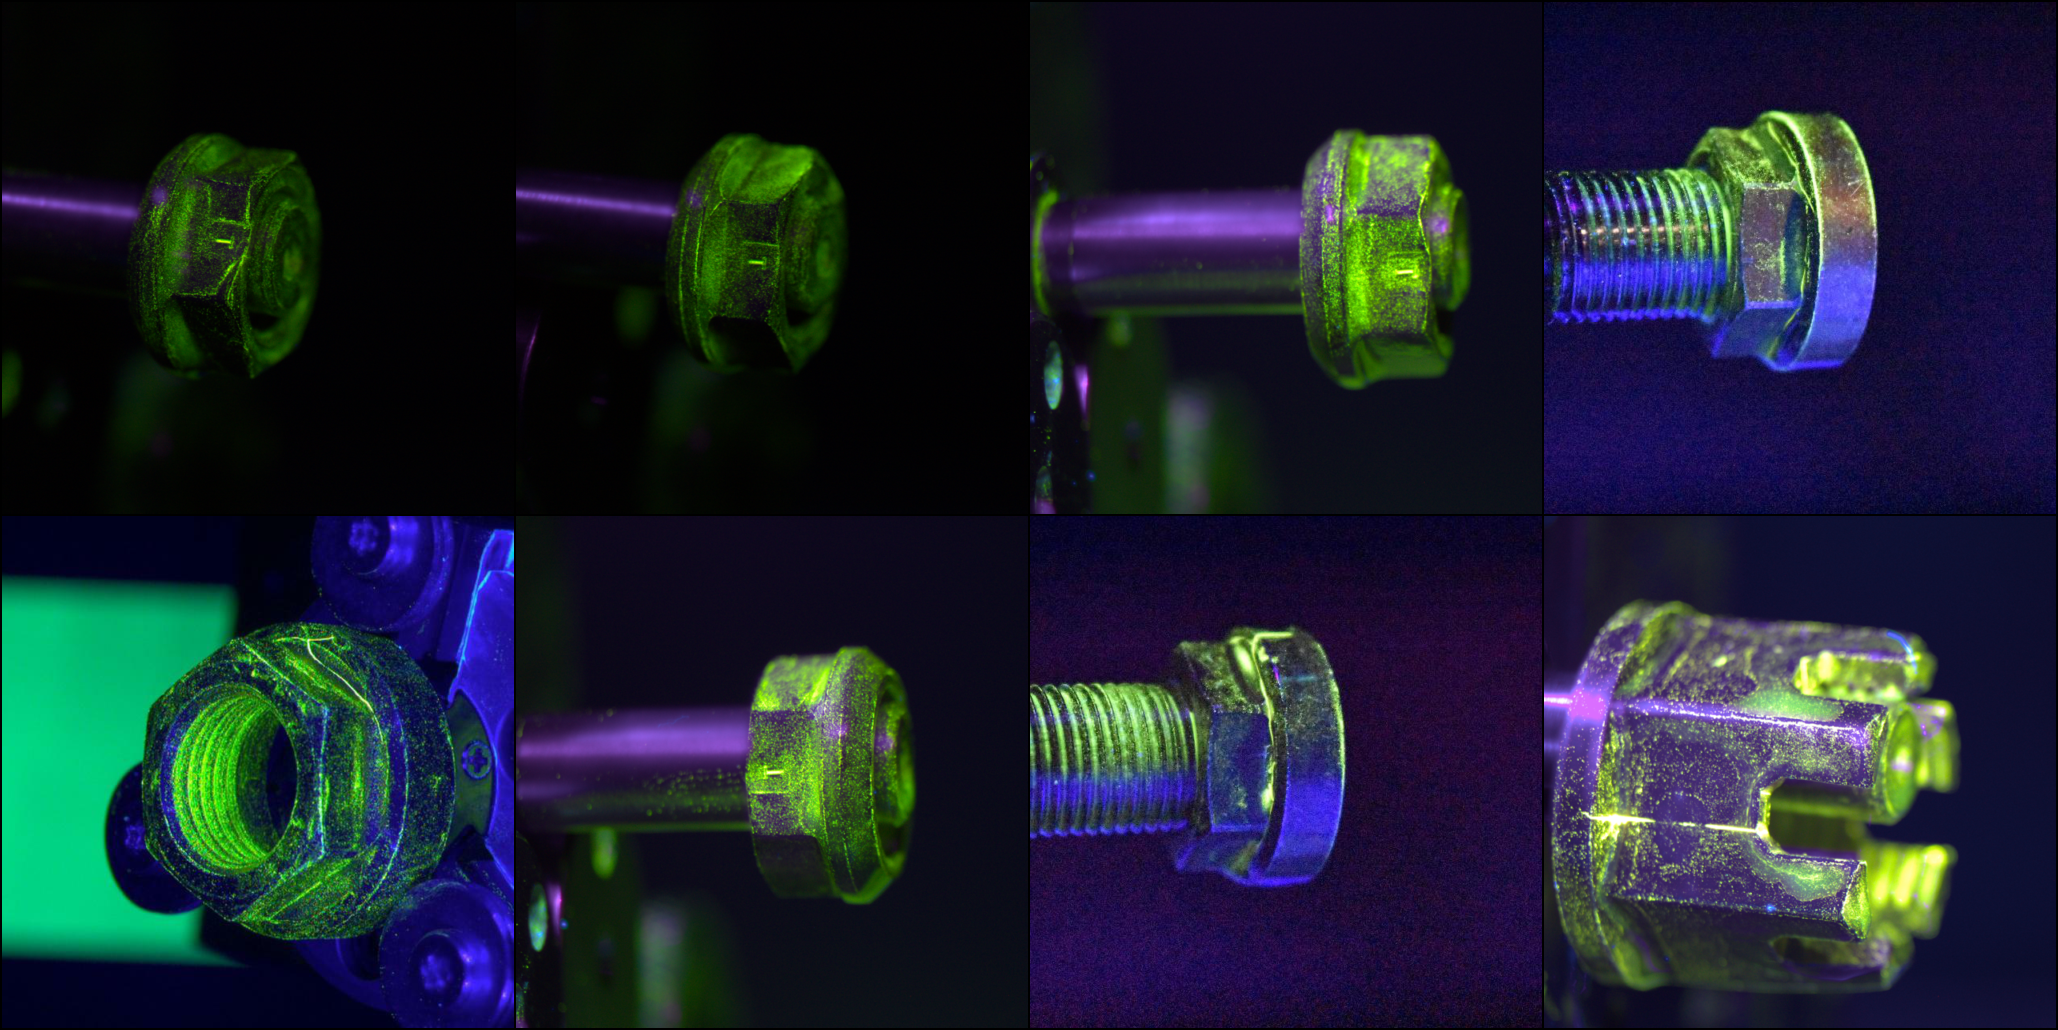

In [ ]:
import plotly.express as px

# Create grid of sample images (training subsample data)
grid_size=8
rnd_inds=np.random.randint(0,len(train_ts),grid_size)
print("image indices:",rnd_inds)

x_grid_train=[train_ts[i][0] for i in rnd_inds]
y_grid_train=[train_ts[i][1] for i in rnd_inds]

x_grid_train=utils.make_grid(x_grid_train, nrow=4, padding=2)
print(x_grid_train.shape)
    
plot_img(x_grid_train,y_grid_train)

### Validation Dataset Examples
Some examples from the validation subset, with corresponding labels.

image indices: [32 53 23 54 26 17 26 23]
torch.Size([3, 1030, 2058])



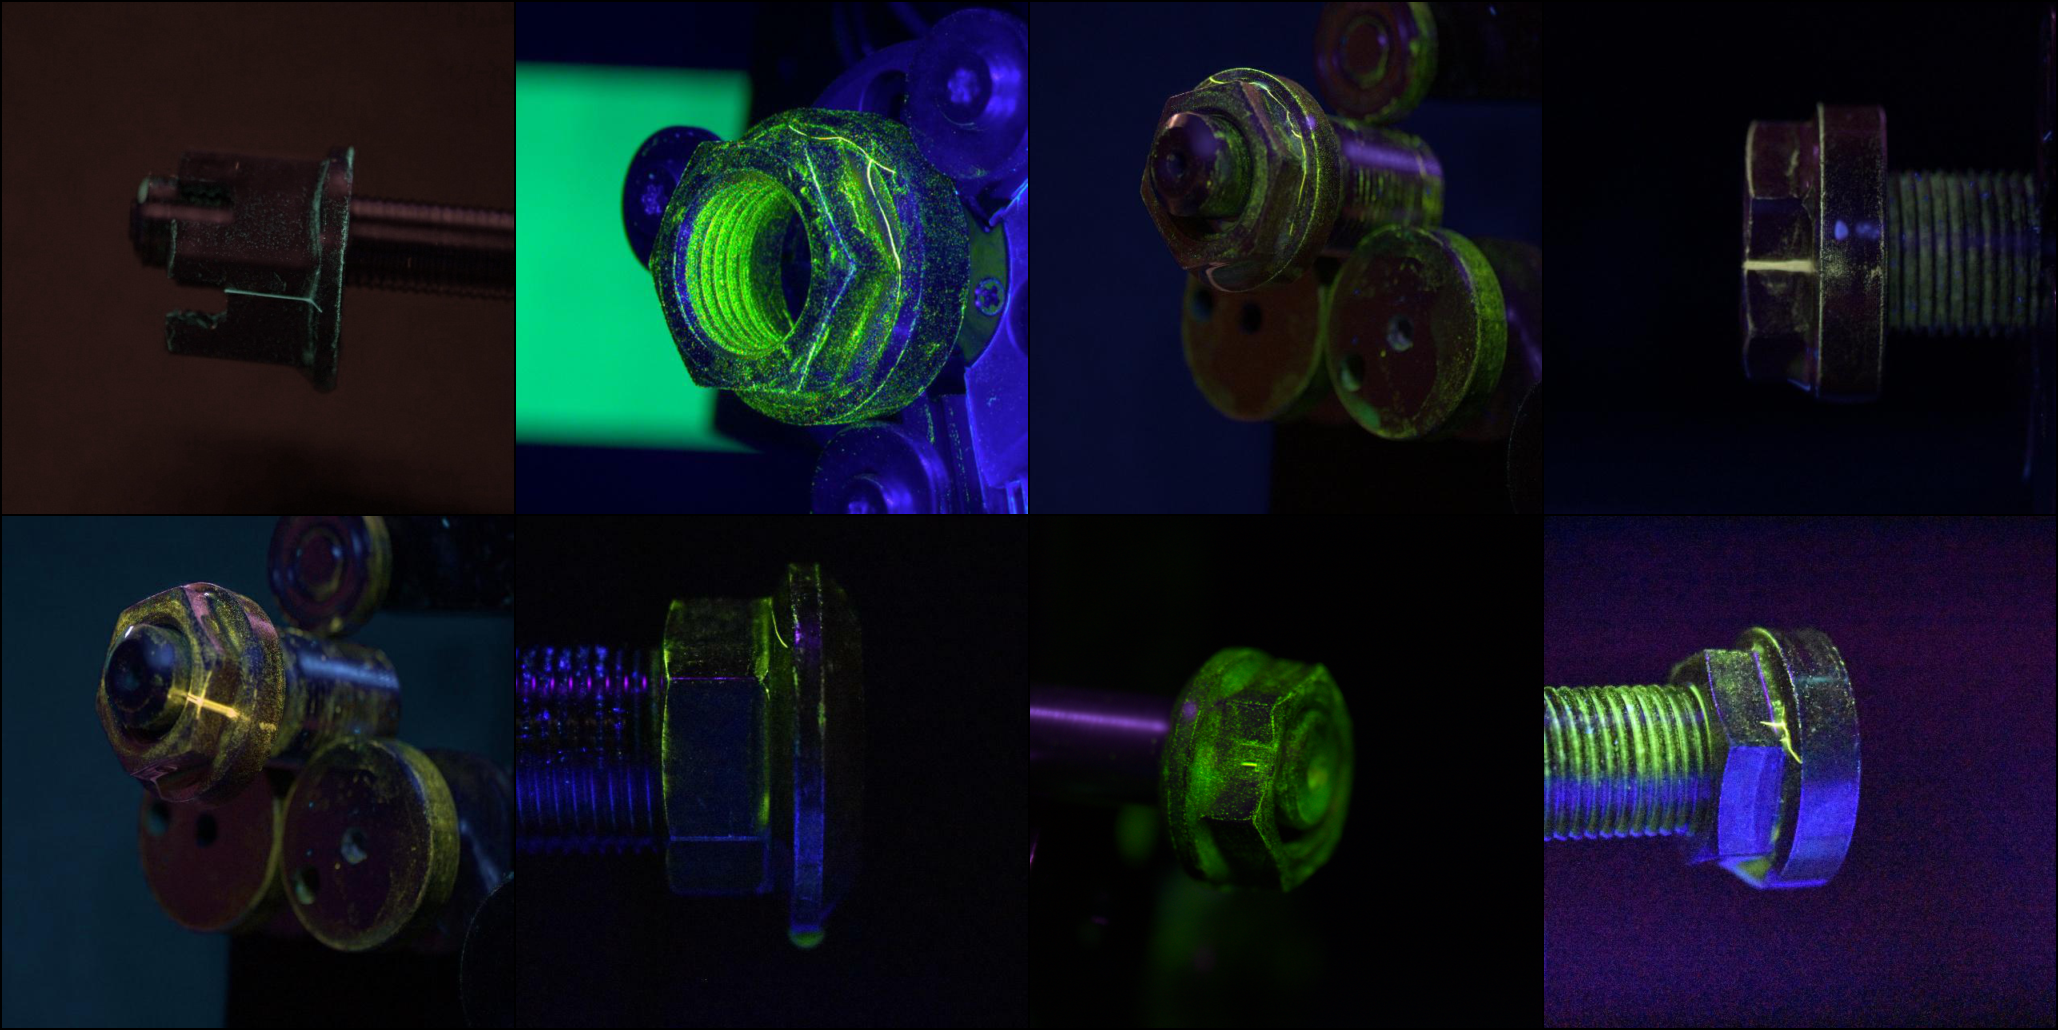

In [ ]:
grid_size=8
rnd_inds=np.random.randint(0,len(val_ts),grid_size)
print("image indices:",rnd_inds)
x_grid_val=[val_ts[i][0] for i in range(grid_size)]
y_grid_val=[val_ts[i][1] for i in range(grid_size)]

x_grid_val=utils.make_grid(x_grid_val, nrow=4, padding=2)
print(x_grid_val.shape)

plot_img(x_grid_val,y_grid_val)

<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#5D2ECC;
       font-size:220%;
       font-family:Nexa;
       letter-spacing:0.5px">
    <p style="padding: 20px;
          color:white;">
        <b>4 |</b> TRANSFORMING THE DATA
    </p>
</div>


In [ ]:
from torchvision.transforms.transforms import Resize
from numpy.core.fromnumeric import resize
# Augmentation
# Define the following transformations for the training dataset
tr_transf = transforms.Compose([
                          
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(45),         
    transforms.RandomResizedCrop(512,scale=(0.8,1.0),ratio=(1.0,1.0)),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
    transforms.ToTensor()])

In [ ]:
# no augmentation for validation and test transfer
val_transf = transforms.Compose([
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
    transforms.ToTensor()])


In [ ]:
# After defining the transformations, overwrite the transform functions of train_ts, val_ts
train_ts.transform = tr_transf
val_ts.transform = val_transf
test_ts.transform = val_transf

<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#5D2ECC;
       font-size:220%;
       font-family:Nexa;
       letter-spacing:0.5px">
    <p style="padding: 20px;
          color:white;">
        <b>5 |</b> CREATING DATALOADERS
    </p>
</div>


In [ ]:
# Define two dataloaders for the datasets

from torch.utils.data import DataLoader
train_dl = DataLoader(train_ts, batch_size=64,shuffle=True)
val_dl = DataLoader(val_ts, batch_size=64, shuffle=False)
test_dl = DataLoader(test_ts, batch_size=64, shuffle=False)

dataloaders  = {"train" : train_dl,"val" : val_dl, "test" : test_dl} 

In [ ]:
for x,y in train_dl:
    print(x.shape,y)
    break

torch.Size([64, 3, 512, 512]) tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1])


In [ ]:
# Create device for using CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#5D2ECC;
       font-size:220%;
       font-family:Nexa;
       letter-spacing:0.5px">
    <p style="padding: 20px;
          color:white;">
        <b>6 |</b> BUILDING A CLASSIFICATION MODEL
    </p>
</div>



In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
#freezing last layer
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
from torchsummary import summary
summary(model_conv, input_size=(3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
       BasicBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#5D2ECC;
       font-size:220%;
       font-family:Nexa;
       letter-spacing:0.5px">
    <p style="padding: 20px;
          color:white;">
        <b>7 |</b> TRAINING
    </p>
</div>

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    loss_history={"train": [],"val": []} # history of loss values in each epoch
    metric_history={"train": [],"val": []} # histroy of metric values in each epoch
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
              loss_history["train"].append(epoch_loss)
              metric_history["train"].append(epoch_acc)
            if phase == 'val':
              loss_history["val"].append(epoch_loss)
              metric_history["val"].append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,loss_history,metric_history

In [ ]:
num_epochs = 50
model_conv,loss_history,metric_history = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=num_epochs)

Epoch 0/49
----------
train Loss: 0.7268 Acc: 0.4932
val Loss: 0.4395 Acc: 0.8182

Epoch 1/49
----------
train Loss: 0.5715 Acc: 0.7215
val Loss: 0.4365 Acc: 0.8182

Epoch 2/49
----------
train Loss: 0.5151 Acc: 0.7215
val Loss: 0.4321 Acc: 0.8182

Epoch 3/49
----------
train Loss: 0.3171 Acc: 0.8950
val Loss: 0.6016 Acc: 0.7818

Epoch 4/49
----------
train Loss: 0.2569 Acc: 0.9863
val Loss: 0.4412 Acc: 0.8909

Epoch 5/49
----------
train Loss: 0.1810 Acc: 0.9863
val Loss: 0.2342 Acc: 0.9818

Epoch 6/49
----------
train Loss: 0.1369 Acc: 0.9954
val Loss: 0.1721 Acc: 0.9818

Epoch 7/49
----------
train Loss: 0.1176 Acc: 0.9909
val Loss: 0.1540 Acc: 0.9818

Epoch 8/49
----------
train Loss: 0.1254 Acc: 0.9817
val Loss: 0.1384 Acc: 0.9818

Epoch 9/49
----------
train Loss: 0.1142 Acc: 0.9909
val Loss: 0.1200 Acc: 0.9818

Epoch 10/49
----------
train Loss: 0.1191 Acc: 0.9909
val Loss: 0.1105 Acc: 0.9818

Epoch 11/49
----------
train Loss: 0.1155 Acc: 0.9772
val Loss: 0.1003 Acc: 0.9818

Ep

<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#5D2ECC;
       font-size:220%;
       font-family:Nexa;
       letter-spacing:0.5px">
    <p style="padding: 20px;
          color:white;">
        <b>8 |</b> EVALUATION
    </p>
</div>

In [ ]:
epochs= num_epochs

fig = make_subplots(rows=1, cols=1,subplot_titles=['lost_history','metric_history'])
fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=loss_history["train"],name='loss_history["train"]'),row=1, col=1)
fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=loss_history["val"],name='loss_history["val"]'),row=1, col=1)
fig.update_layout(template='plotly_white');fig.update_layout(margin={"r":0,"t":60,"l":0,"b":0},height=300)
fig.show()

<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#5D2ECC;
       font-size:220%;
       font-family:Nexa;
       letter-spacing:0.5px">
    <p style="padding: 20px;
          color:white;">
        <b>9 |</b> TEST
    </p>
</div>

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

In [ ]:
def visualize_model(model, num_images=6):
    class_names = ["NoT","T"]
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

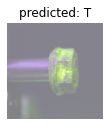

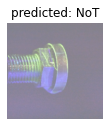

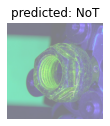

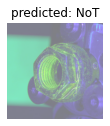

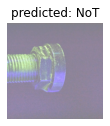

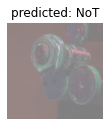

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()